# Matrix multiplication from foundations

In [102]:
import matplotlib as mpl
import matplotlib.pyplot as plt

## Get data

In [103]:
from pathlib import Path

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [104]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [105]:
!ls -l data

total 33344
-rw-r--r--  1 wig  staff  17051982 Jan 17 18:26 mnist.pkl.gz


In [106]:
import gzip, pickle
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

## Chunks

In [107]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [108]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [109]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

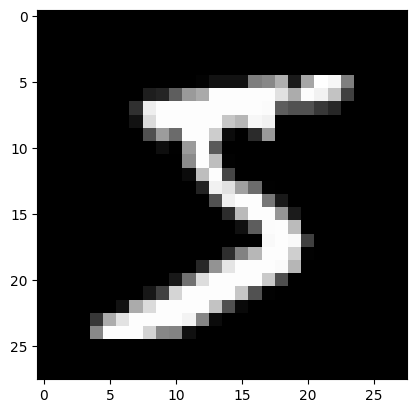

In [110]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

### islice

In [111]:
from itertools import islice
it = iter(vals)
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

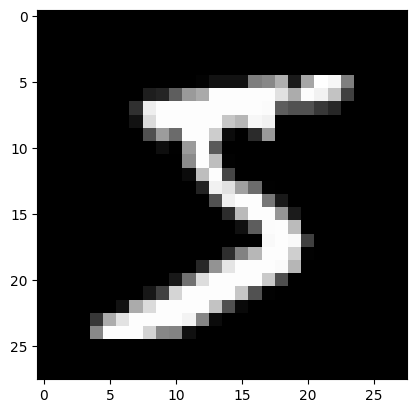

In [112]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))
plt.imshow(img);

## Matrix and tensor

In [113]:
img[20][15]

0.98828125

In [114]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [115]:
m = Matrix(img)
m[20,15]

0.98828125

In [116]:
import torch
from torch import tensor

tensor([1,2,3])

tensor([1, 2, 3])

In [117]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [118]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

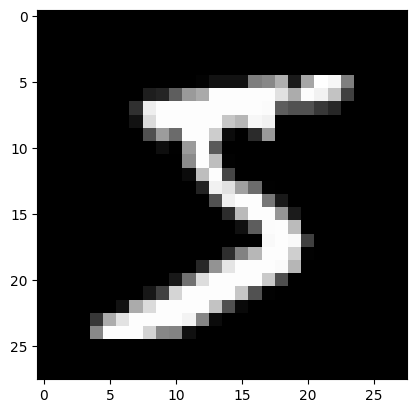

In [119]:
plt.imshow(imgs[0]);

In [120]:
imgs[0,20,15]

tensor(0.99)

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3

In [121]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [122]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [123]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

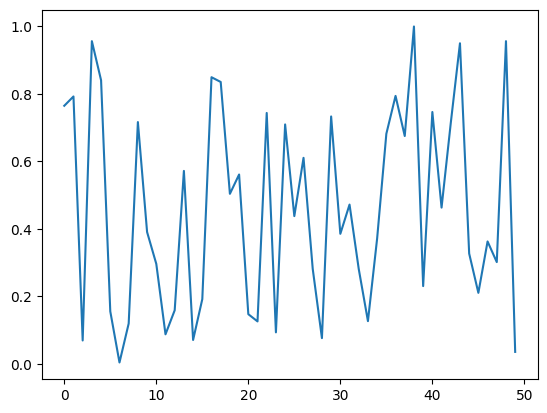

In [124]:
plt.plot([rand() for _ in range(50)]);

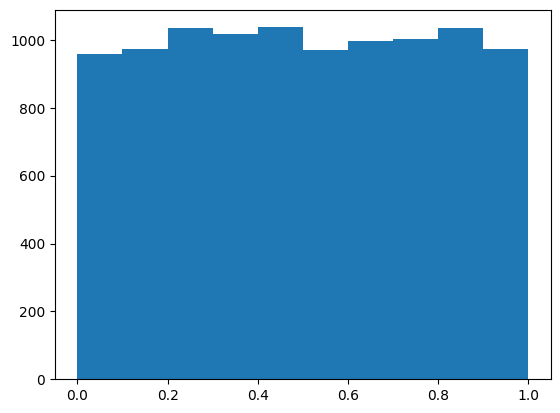

In [125]:
plt.hist([rand() for _ in range(10000)]);

In [126]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

2.31 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
%timeit -n 10 torch.randn(784,10)


90.3 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [128]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [129]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [130]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [131]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [132]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [133]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [134]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [135]:
%time _=matmul(m1, m2)

CPU times: user 416 ms, sys: 5.08 ms, total: 421 ms
Wall time: 422 ms


## Numba

In [136]:
from numba import njit
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [137]:
from numpy import array
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 41.4 ms, sys: 3.09 ms, total: 44.5 ms
Wall time: 43.9 ms


20.0

The first time numba is relatively slow because of initializing

In [138]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.1 µs


20.0

Now only two of our loops are running in Python, not three:

In [139]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [140]:
m1a,m2a = m1.numpy(),m2.numpy()

In [141]:
from fastcore.test import *
test_close(t1,matmul(m1a, m2a))
%timeit -n 50 matmul(m1a,m2a)

222 µs ± 5.57 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

In [142]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [143]:
a + b

tensor([12., 14.,  3.])

In [144]:
(a < b).float().mean()

tensor(0.67)

In [145]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [146]:
sf = (m*m).sum()
sf

tensor(285.)

In [147]:
sf.sqrt()

tensor(16.88)

In [148]:
m[2,:],m[:,2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [149]:
m[2]

tensor([7., 8., 9.])

In [150]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [151]:
test_close(t1,matmul(m1, m2))
%timeit -n 50 _=matmul(m1, m2)

526 µs ± 6.48 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [152]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [153]:
test_close(t1,matmul(m1, m2))
%timeit -n 50 _=matmul(m1, m2)

434 µs ± 4.93 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

In [154]:
a

tensor([10.,  6., -4.])

In [155]:
a > 0

tensor([ True,  True, False])

In [156]:
a + 1

tensor([11.,  7., -3.])

In [157]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [158]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [159]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [160]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [161]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [162]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [163]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [164]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [165]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [166]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [167]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

In [168]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [169]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [170]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [171]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [172]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [173]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

## Matmul with broadcasting

In [174]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [175]:
digit[:,None].shape

torch.Size([784, 1])

In [176]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [177]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [178]:
test_close(t1,matmul(m1, m2))
%timeit -n 50 _=matmul(m1, m2)

61.5 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [179]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [180]:
%time _=matmul(x_train, weights)

CPU times: user 573 ms, sys: 11.8 ms, total: 585 ms
Wall time: 584 ms


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [181]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [182]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [183]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [184]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [185]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [186]:
test_close(tr, matmul(x_train, weights), eps=1e-3)
%timeit -n 5 _=matmul(x_train, weights)

4.67 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op

In [187]:
test_close(tr, x_train@weights, eps=1e-3)
%timeit -n 5 _=torch.matmul(x_train, weights)

4.35 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [188]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [189]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [190]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [191]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [192]:
from numba import cuda
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [193]:
import numpy as np
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [195]:
import math
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [196]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

NameError: name 'm1g' is not defined

In [197]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

NameError: name 'm1g' is not defined

In [198]:
m1c,m2c = x_train.cuda(),weights.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [199]:
r=(m1c@m2c).cpu()

NameError: name 'm1c' is not defined

In [200]:
%timeit -n 10 r=(m1c@m2c).cpu()

NameError: name 'm1c' is not defined

Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!